# **Imports**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from keras.preprocessing.image import ImageDataGenerator
from prettytable import PrettyTable

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import MobileNet

In [ ]:
import tensorflow as tf 
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


# **Data**

In [ ]:
mainDIR = os.listdir('/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)')
print(mainDIR)

['train', 'val', 'test']


In [ ]:
train_folder= '/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/train'
val_folder = '/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/val'
test_folder = '/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/test'

In [ ]:
# function to calculate viral/bac in a path
def stat_viral_bac(path):
  #stats train pneumonia viral/bacterial
  bac_str ="bacteria"
  cpt_bac = 0
  cpt_vir = 0
  for image_name in os.listdir(path) :
        if bac_str in image_name :
          cpt_bac += 1
        else :
          cpt_vir += 1
  return cpt_bac,cpt_vir 

In [ ]:
# statestics after augmenting the dataset (closing the gap and noise)
# stats train
num_train_normal = len(os.listdir(train_folder+'/Normal'))
num_train_pneumonia = len(os.listdir('/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/train/Pneumonia'))
TOT_train = num_train_normal + num_train_pneumonia
# stats test
num_test_normal = len(os.listdir('/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/test/Normal'))
num_test_pneumonia = len(os.listdir('/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/test/Pneumonia'))
TOT_test = num_test_pneumonia + num_test_normal
# stats valdidation
num_valid_normal = len(os.listdir('/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/val/Normal'))
num_valid_pneumonia = len(os.listdir('/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/val/Pneumonia'))
TOT_valid = num_valid_normal + num_valid_pneumonia

# stats train viral/bac
num_train_bac,num_train_vir = stat_viral_bac('/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/train/Pneumonia')
# stats test viral/bac
num_test_bac,num_test_vir = stat_viral_bac('/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/test/Pneumonia')
# stats validation viral/bac
num_val_bac,num_val_vir = stat_viral_bac('/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/val/Pneumonia')

TOT_train_vb = num_train_bac +num_train_vir
TOT_test_vb = num_test_bac + num_test_vir
TOT_valid_vb = num_val_bac + num_val_vir 
#table stat general
t = PrettyTable(['Class','Train','Validation', 'Test'])
t.add_row(['Normal',num_train_normal,num_valid_normal,num_test_normal])
t.add_row(['Pneumonia',num_train_pneumonia,num_valid_pneumonia,num_test_pneumonia])
t.add_row(['Total',TOT_train,TOT_valid,TOT_test])
print(t)

#table Pneumonia
print('\nPneumonia')
t = PrettyTable(['Class','Train','Validation' ,'Test'])
t.add_row(['Pneumonia viral',num_train_vir,num_val_vir,num_test_vir])
t.add_row(['Pneumonia bacterial',num_train_bac,num_val_bac,num_test_bac])
t.add_row(['Total',TOT_train_vb,TOT_valid_vb,TOT_test_vb])
print(t)

+-----------+-------+------------+------+
|   Class   | Train | Validation | Test |
+-----------+-------+------------+------+
|   Normal  |  2659 |    237     | 238  |
| Pneumonia |  3589 |    640     | 642  |
|   Total   |  6248 |    877     | 880  |
+-----------+-------+------------+------+

Pneumonia
+---------------------+-------+------------+------+
|        Class        | Train | Validation | Test |
+---------------------+-------+------------+------+
|   Pneumonia viral   |  1242 |    201     | 236  |
| Pneumonia bacterial |  2347 |    439     | 406  |
|        Total        |  3589 |    640     | 642  |
+---------------------+-------+------------+------+


In [ ]:
def claheImage(img): #Nada
    # convert image to LAB color space
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    gray = cv2.convertScaleAbs(gray)
    # apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(gray)

    # convert the LAB image back to RGB color space
    final = cv2.cvtColor(cl, cv2.COLOR_GRAY2BGR)
    cl_img = np.float64(final)
    return cl_img

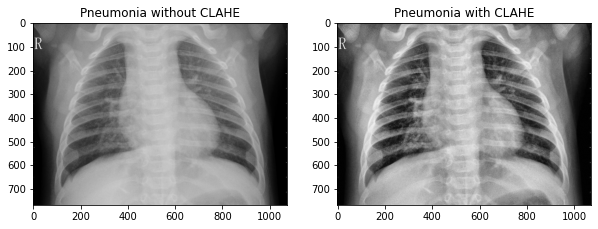

In [ ]:
#plot Pneumonia image with/without CLAHE
fig = plt.figure(figsize=(10, 10))
columns = 2 
rows = 1
fig.add_subplot(rows, columns, 1)
plt.title('Pneumonia without CLAHE')
plt.imshow(cv2.imread('/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/train/Pneumonia/person1000_virus_1681.jpeg')/255)

fig.add_subplot(rows, columns, 2)
plt.title('Pneumonia with CLAHE')
plt.imshow(claheImage(cv2.imread('/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/train/Pneumonia/person1000_virus_1681.jpeg'))/255)
plt.show()

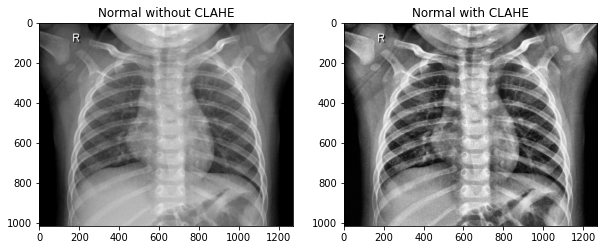

In [ ]:
#plot Normal image with/without CLAHE
fig = plt.figure(figsize=(10, 10))
columns = 2 
rows = 1
fig.add_subplot(rows, columns, 1)
plt.title('Normal without CLAHE')
plt.imshow(cv2.imread('/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/train/Normal/IM-0549-0001.jpeg')/255)

fig.add_subplot(rows, columns, 2)
plt.title('Normal with CLAHE')
plt.imshow(claheImage(cv2.imread('/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/train/Normal/IM-0549-0001.jpeg'))/255)
plt.show()

# **Model**

In [ ]:
# data gens
with tf.device(device_name):
  train_datagen = ImageDataGenerator(rescale = 1./255,
                                    rotation_range=10,
                                    shear_range = 20,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    preprocessing_function = claheImage
                                    )

  test_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function = claheImage)  #Image normalization.
  val_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function = claheImage)  #Image normalization.

  training_set = train_datagen.flow_from_directory(train_folder,
                                                  target_size = (224, 224),
                                                  batch_size = 32,
                                                  class_mode = 'binary'
                                                  )

  validation_set = val_datagen.flow_from_directory(val_folder,
                                                      target_size=(224, 224),
                                                      batch_size=32,
                                                      class_mode='binary'
                                                      )

  test_set = test_datagen.flow_from_directory(test_folder,
                                              target_size = (224, 224),
                                              class_mode = 'binary',
                                              batch_size = 1,
                                              shuffle = False)

Found 6248 images belonging to 2 classes.
Found 877 images belonging to 2 classes.
Found 880 images belonging to 2 classes.


In [ ]:
with tf.device(device_name):
  # Load the pre-trained MobileNet model without the top layer
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
with tf.device(device_name):
  number_of_layers = len(base_model.layers)

In [ ]:
# Freeze the % layers in the base model
percent = 0.32
number_of_layers_to_freeze =  int(number_of_layers * percent)
with tf.device(device_name):
  # Freeze some layers
  for layer in base_model.layers[:number_of_layers_to_freeze]:
      layer.trainable = False

In [ ]:
# description of the model
with tf.device(device_name):
  model = Sequential()
  model.add(base_model)
  model.add(GlobalAveragePooling2D())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
  model.add(Dense(2, activation='softmax'))

In [ ]:
with tf.device(device_name):
  model.compile(
    optimizer="adam",
    loss='sparse_categorical_crossentropy',
    metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_4 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                      

In [ ]:
# callbacks
from tensorflow.keras import callbacks
with tf.device(device_name):
  early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

  plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

  checkpoint = callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/models/Model 07-03/best_model.h5', 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', verbose=1
)

In [ ]:
# train
with tf.device(device_name):
  history = model.fit(training_set,validation_data = validation_set,epochs=50,batch_size = 32,
                      steps_per_epoch=(6257 /32),# fuck
                      validation_steps=(877 /32),
                      callbacks=[early_stopping, plateau,checkpoint])

Epoch 1/50
196/195 [==============================] - ETA: 0s - loss: 4.9568 - acc: 0.8851
Epoch 1: val_loss improved from inf to 1.28288, saving model to /content/drive/MyDrive/models/Model 07-03/best_model.h5
195/195 [==============================] - 228s 1s/step - loss: 4.9568 - acc: 0.8851 - val_loss: 1.2829 - val_acc: 0.8495 - lr: 0.0010
Epoch 2/50
196/195 [==============================] - ETA: 0s - loss: 0.5275 - acc: 0.9323
Epoch 2: val_loss improved from 1.28288 to 0.28881, saving model to /content/drive/MyDrive/models/Model 07-03/best_model.h5
195/195 [==============================] - 192s 980ms/step - loss: 0.5275 - acc: 0.9323 - val_loss: 0.2888 - val_acc: 0.9179 - lr: 0.0010
Epoch 3/50
196/195 [==============================] - ETA: 0s - loss: 0.2174 - acc: 0.9429
Epoch 3: val_loss improved from 0.28881 to 0.17212, saving model to /content/drive/MyDrive/models/Model 07-03/best_model.h5
195/195 [==============================] - 178s 910ms/step - loss: 0.2174 - acc: 0.942

In [ ]:
import pickle
# sauvgarder le model
model.save('/content/drive/MyDrive/models/Model 07-03/last_epoch_model.h5')
# save history
with open('/content/drive/MyDrive/models/Model 07-03/history.pkl', 'wb') as file:
    pickle.dump(history.history, file)



*   Learning Curve (Loss)




In [ ]:
import seaborn as sns

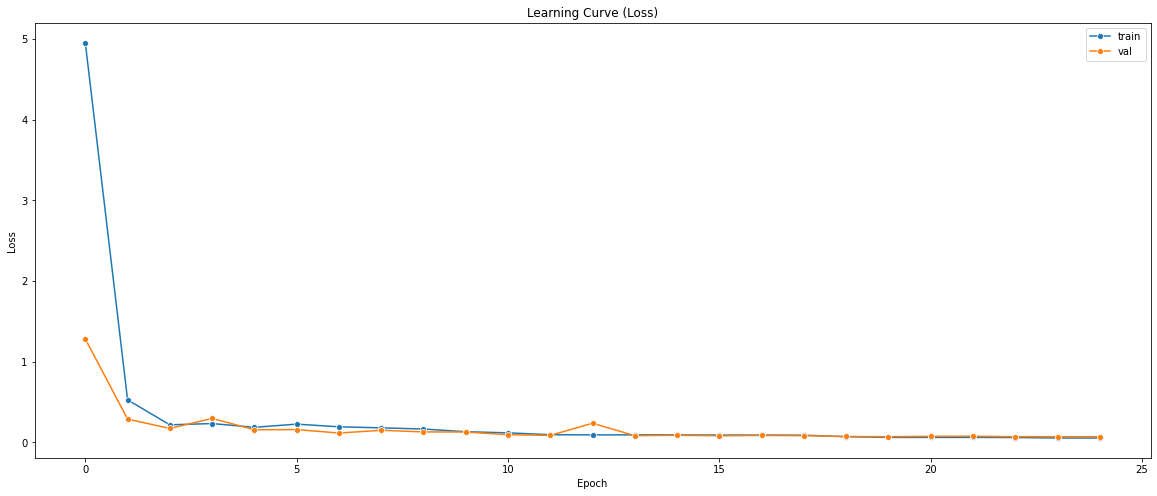

In [ ]:
# Learning Curve (Loss)
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'],  marker="o")
sns.lineplot(x = history.epoch, y = history.history['val_loss'], marker="o")
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['train', 'val'], loc='best')
plt.savefig('/content/drive/MyDrive/models/Model 07-03/Learning Curve (Loss).png')
plt.show()

*   Learning Curve (Accuracy)

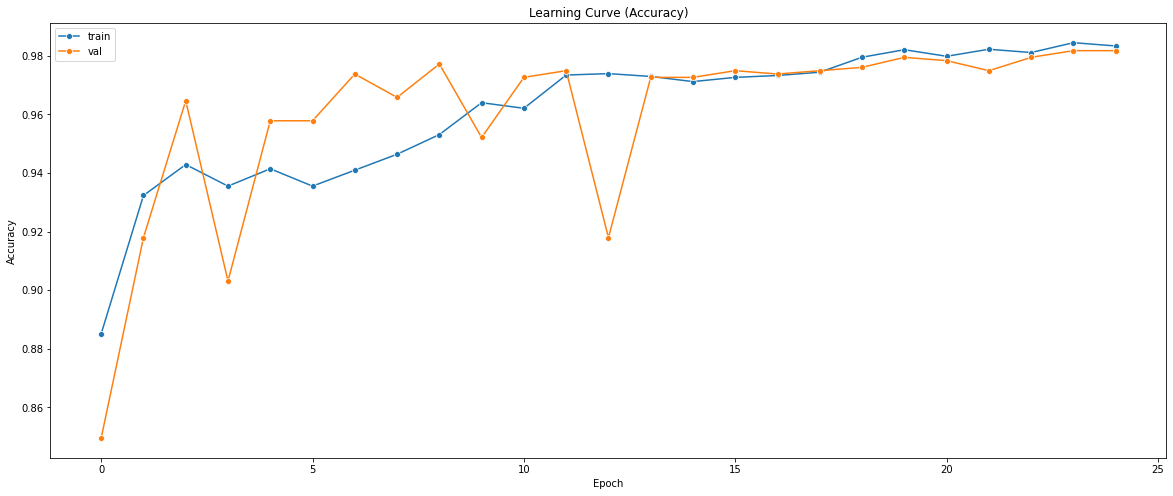

In [ ]:
# Learning Curve (Accuracy)
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['acc'],marker="o")
sns.lineplot(x = history.epoch, y = history.history['val_acc'],marker="o")
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(['train', 'val'], loc='best')
plt.savefig('/content/drive/MyDrive/models/Model 07-03/Learning Curve (Accuracy).png')
plt.show()

# **Performance Metrics**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve ,auc

In [ ]:
#load best model
model = tf.keras.models.load_model('/content/drive/MyDrive/models/Model 07-03 (32% frozen PARFAIT)/best_model.h5')



*   Test evaluation



In [ ]:
# test evaluation
with tf.device(device_name):
  test_loss, test_acc = model.evaluate(test_set)
  print('Test accuracy:', test_acc)
  print('Test loss:', test_loss)

880/880 [==============================] - 202s 219ms/step - loss: 0.0855 - acc: 0.9784
Test accuracy: 0.9784091114997864
Test loss: 0.08554549515247345




*   Confusion matrix



In [ ]:
with tf.device(device_name):
  test_set.reset()
  Y_pred = model.predict(test_set)
  y_pred = np.argmax(Y_pred, axis=1)

880/880 [==============================] - 17s 18ms/step


In [ ]:
confusion_matrix_res  = confusion_matrix(test_set.classes, y_pred)

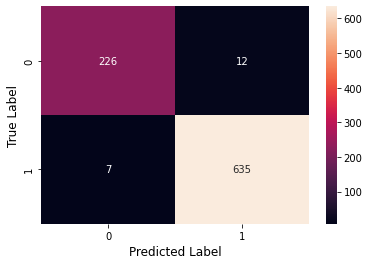

In [ ]:
sns.heatmap(confusion_matrix_res, annot=True, fmt="d")
plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)
plt.savefig('/content/drive/MyDrive/models/Model 07-03 (32% frozen PARFAIT)/confusion_matrix_res.png')
plt.show()



*   precision  -  recall - f1-score - support



In [ ]:
print(classification_report(test_set.classes, y_pred, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       238
           1       0.98      0.99      0.99       642

    accuracy                           0.98       880
   macro avg       0.98      0.97      0.97       880
weighted avg       0.98      0.98      0.98       880





*  ROC Curve



ROC_AUC:  0.9960142935678945


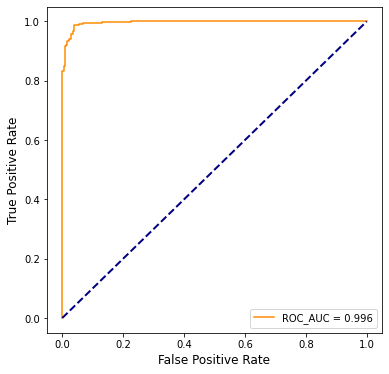

In [ ]:
# Select the second column to obtain the predicted probabilities of the positive class
# fpr -> false positive rate tpr-> true positive rate
fpr, tpr, thresholds = roc_curve(test_set.classes, Y_pred[:,1])

# calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)
print('ROC_AUC: ', roc_auc)

# plot the ROC curve
plt.subplots(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', label = 'ROC_AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/models/Model 07-03 (32% frozen PARFAIT)/COURBE ROC avec AUC.png')
plt.show()

In [ ]:
# load the saved model from file
with open('/content/drive/MyDrive/models/Model 07-03/history.pkl', 'rb') as file:
    model = pickle.load(file)

# access the history attribute of the model
print(model)

{'loss': [4.956803798675537, 0.5274673700332642, 0.21742413938045502, 0.23305849730968475, 0.18640676140785217, 0.22595664858818054, 0.19293637573719025, 0.17985260486602783, 0.16535361111164093, 0.13198164105415344, 0.11791694164276123, 0.09489888697862625, 0.09234435856342316, 0.09321443736553192, 0.0920778438448906, 0.09019702672958374, 0.09010238945484161, 0.08916693180799484, 0.06988336145877838, 0.061451174318790436, 0.06170333921909332, 0.06179104372859001, 0.05987509340047836, 0.05359962582588196, 0.05418982729315758], 'acc': [0.8850831985473633, 0.9322983622550964, 0.9428617358207703, 0.935499370098114, 0.9414212703704834, 0.935499370098114, 0.9409410953521729, 0.9463828206062317, 0.9531049728393555, 0.9639884829521179, 0.9620678424835205, 0.9734315276145935, 0.9739116430282593, 0.972951352596283, 0.9711908102035522, 0.9726312160491943, 0.9732714295387268, 0.9743918180465698, 0.9795134663581848, 0.9820742607116699, 0.9798335433006287, 0.9822342991828918, 0.9811139702796936, 0.